# SHAPELETS LEARNING DEMO WITH VALIDATION SET

In [1]:
import sys
sys.path.append('../')

import torch
from torch import tensor

import numpy as np
import random

from tslearn.datasets import CachedDatasets, UCR_UEA_datasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance

from src.preprocessing_anomaly import preprocessing_anomaly
from src.learning.learningextractor import LearningShapelets
from src.SVDD.SVDD import SVDD
from src.util import Scaler, get_weights_via_kmeans

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

/opt/anaconda3/envs/ludo_env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Change Length of the shapelets

Length = 15


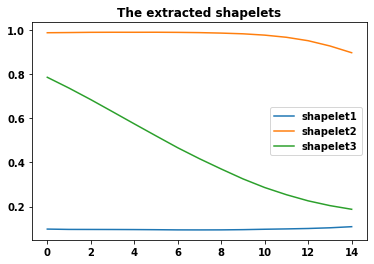

Validation balanced accuracy: 0.8275862068965517
Validation AUC: 0.9717868338557993
Validation F1 score: 0.6875000000000001
Length = 25


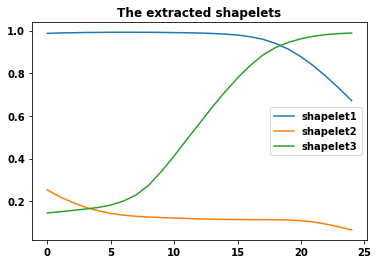

Validation balanced accuracy: 0.7821316614420062
Validation AUC: 0.9529780564263323
Validation F1 score: 0.6451612903225806
Length = 40


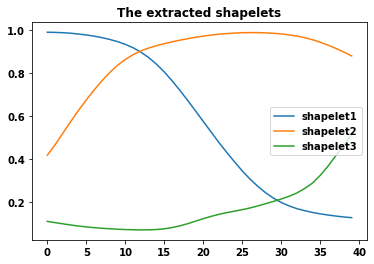

Validation balanced accuracy: 0.7068965517241379
Validation AUC: 0.8871473354231976
Validation F1 score: 0.5641025641025641
Length = 60


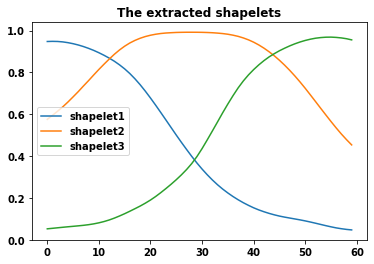

Validation balanced accuracy: 0.5344827586206896
Validation AUC: 0.664576802507837
Validation F1 score: 0.4489795918367347
Length = 80


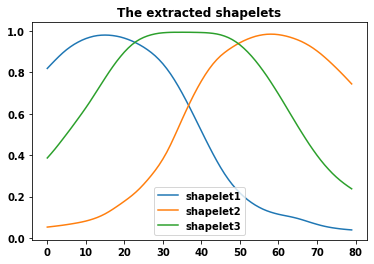

Validation balanced accuracy: 0.5689655172413793
Validation AUC: 0.6332288401253918
Validation F1 score: 0.46808510638297873


In [3]:
data_name = "GunPoint"
X_train = np.load(f'../demo/data/{data_name}_train.npy')
y_train = np.load(f'../demo/data/{data_name}_train_labels.npy')
X_test = np.load(f'../demo/data/{data_name}_test.npy')
y_test = np.load(f'../demo/data/{data_name}_test_labeles.npy')


# Set seed for determinism
np.random.seed(0)

# Set up anomaly detection dataset

normal_class = 1
alpha = 0.05 # proportion of anomalies wrt normal 
normal_prop = 0.8 # proportion of normal samples that go in train set
valid_prop = 0 # proportion of validation data w.r.t. total data \ train data

X_train_anomaly, y_train_anomaly, X_test_anomaly, y_test_anomaly, X_valid_anomaly, y_valid_anomaly = preprocessing_anomaly(X_train, \
    y_train, X_test, y_test, alpha, normal_class, normal_prop, valid_prop)

# normalize the time series
# as in the tutorial https://tslearn.readthedocs.io/en/stable/auto_examples/classification/plot_shapelets.html#sphx-glr-auto-examples-classification-plot-shapelets-py
scaler = TimeSeriesScalerMinMax()
X_train_anomaly = scaler.fit_transform(X_train_anomaly)
X_test_anomaly = scaler.fit_transform(X_test_anomaly)
X_valid_anomaly = scaler.fit_transform(X_valid_anomaly)

N, Q, n_channels = X_train_anomaly.shape

K = 3
for L in [15, 25, 40, 60, 80]:
    print(f'Length = {L}')
    clusters_centers = get_weights_via_kmeans(X_train_anomaly, len_shapelets=L, num_shapelets=K, n_segments=10000)
    # set_shapelet_weights needs input of shape (num_shapelets, in_channels, len_shapelets)
    clusters_centers = clusters_centers.transpose(0,2,1)
    
    C = 1 / (N * alpha)
    extractor = LearningShapelets(len_shapelets=L, num_shapelets=K, in_channels=n_channels, C=C, verbose=0, to_cuda=False)
    extractor.set_shapelet_weights(clusters_centers)
    
    
    lr = 1e-3
    optimizer = torch.optim.SGD(extractor.model.parameters() ,lr=lr)
    extractor.set_optimizer(optimizer)
    
    n_epoch_steps = 20
    n_epochs = 4
    # total epochs = n_epoch_steps * n_epochs
    batch_size = 8
    
    # Input shape must be a pytorch TENSOR with shape (n_samples, in_channels, len_ts)
    X_train_tensor = tensor(X_train_anomaly, dtype=torch.float).contiguous().transpose(1,2)
    
    extractor.compute_radius(X_train_tensor, tol=1e-7)
    
    losses = []
    for _ in range(n_epoch_steps):
        extractor.compute_radius(X_train_tensor)
        losses += extractor.fit(X_train_tensor, epochs=n_epochs, batch_size=batch_size)
    
    # plot the shapelets
    
    S = extractor.get_shapelets()
    # use moveaxis because the shapelets returned have shape (num_shapelets, in_channels, shapelets_size)
    S = np.moveaxis(S, 1, 2)
    
    plt.figure()
    for i in range(len(S)):
        shap = S[i,:,]
        plt.plot(shap, label=f'shapelet{i+1}')
    plt.legend()
    plt.title('The extracted shapelets', fontweight="bold")
    plt.show()

    
    X_train_transform = extractor.transform(X_train_tensor)
    
    X_valid_tensor = tensor(X_valid_anomaly, dtype=torch.float).contiguous().transpose(1,2)
    X_valid_transform = extractor.transform(X_valid_tensor)
    
    svdd = SVDD(C=C, kernel='linear', zero_center=True, verbose=False)
    svdd.fit(X_train_transform)
    
    y_valid_predict = svdd.predict(X_valid_transform)
    ba = balanced_accuracy_score(y_valid_anomaly, y_valid_predict)
    
    # AUC
    y_valid_scores = svdd.decision_function(X_valid_transform)
    auc = roc_auc_score(y_valid_anomaly, y_valid_scores)
    
    f1_valid = f1_score(y_valid_anomaly, y_valid_predict)
    
    print(f'Validation balanced accuracy: {ba}')
    print(f'Validation AUC: {auc}')
    print("Validation F1 score:", f1_valid)


Overfitting!!

## Change number of shapelets

Number of shapelets: 2


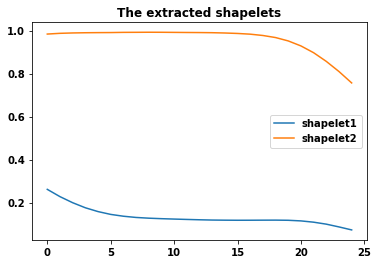

Validation balanced accuracy: 0.7068965517241379
Validation AUC: 0.9905956112852664
Validation F1 score: 0.5641025641025641
Number of shapelets: 5


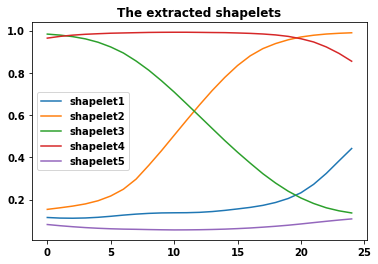

Validation balanced accuracy: 0.7476489028213166
Validation AUC: 0.8589341692789969
Validation F1 score: 0.6060606060606061
Number of shapelets: 10


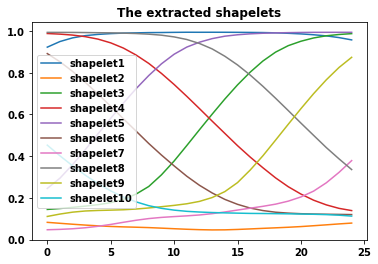

Validation balanced accuracy: 0.8275862068965517
Validation AUC: 0.9686520376175549
Validation F1 score: 0.6875000000000001
Number of shapelets: 15


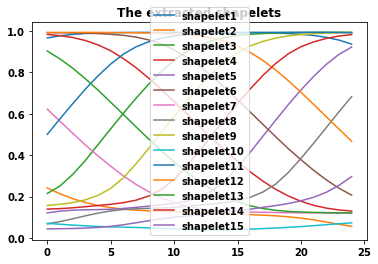

Validation balanced accuracy: 0.7821316614420062
Validation AUC: 0.9686520376175549
Validation F1 score: 0.6451612903225806
Number of shapelets: 20


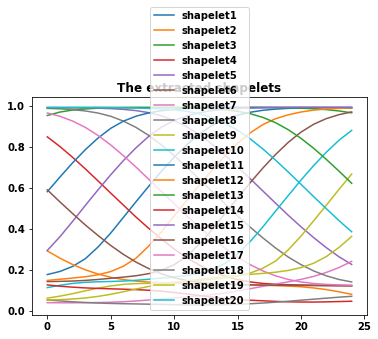

Validation balanced accuracy: 0.8275862068965517
Validation AUC: 0.9686520376175549
Validation F1 score: 0.6875000000000001


In [4]:
L = 25
for K in [2, 5, 10, 15, 20]:
    print(f'Number of shapelets: {K}')
    clusters_centers = get_weights_via_kmeans(X_train_anomaly, len_shapelets=L, num_shapelets=K, n_segments=10000)
    # set_shapelet_weights needs input of shape (num_shapelets, in_channels, len_shapelets)
    clusters_centers = clusters_centers.transpose(0,2,1)
    
    C = 1 / (N * alpha)
    extractor = LearningShapelets(len_shapelets=L, num_shapelets=K, in_channels=n_channels, C=C, verbose=0, to_cuda=False)
    extractor.set_shapelet_weights(clusters_centers)
    
    
    lr = 1e-3
    optimizer = torch.optim.SGD(extractor.model.parameters() ,lr=lr)
    extractor.set_optimizer(optimizer)
    
    n_epoch_steps = 20
    n_epochs = 4
    # total epochs = n_epoch_steps * n_epochs
    batch_size = 8
    
    # Input shape must be a pytorch TENSOR with shape (n_samples, in_channels, len_ts)
    X_train_tensor = tensor(X_train_anomaly, dtype=torch.float).contiguous().transpose(1,2)
    
    extractor.compute_radius(X_train_tensor, tol=1e-7)
    
    losses = []
    for _ in range(n_epoch_steps):
        extractor.compute_radius(X_train_tensor)
        losses += extractor.fit(X_train_tensor, epochs=n_epochs, batch_size=batch_size)
    
    # plot the shapelets
    
    S = extractor.get_shapelets()
    # use moveaxis because the shapelets returned have shape (num_shapelets, in_channels, shapelets_size)
    S = np.moveaxis(S, 1, 2)
    
    plt.figure()
    for i in range(len(S)):
        shap = S[i,:,]
        plt.plot(shap, label=f'shapelet{i+1}')
    plt.legend()
    plt.title('The extracted shapelets', fontweight="bold")
    plt.show()

    
    X_train_transform = extractor.transform(X_train_tensor)
    
    X_valid_tensor = tensor(X_valid_anomaly, dtype=torch.float).contiguous().transpose(1,2)
    X_valid_transform = extractor.transform(X_valid_tensor)
    
    svdd = SVDD(C=C, kernel='linear', zero_center=True, verbose=False)
    svdd.fit(X_train_transform)
    
    y_valid_predict = svdd.predict(X_valid_transform)
    ba = balanced_accuracy_score(y_valid_anomaly, y_valid_predict)
    
    # AUC
    y_valid_scores = svdd.decision_function(X_valid_transform)
    auc = roc_auc_score(y_valid_anomaly, y_valid_scores)
    
    f1_valid = f1_score(y_valid_anomaly, y_valid_predict)
    
    print(f'Validation balanced accuracy: {ba}')
    print(f'Validation AUC: {auc}')
    print("Validation F1 score:", f1_valid)

## Change parameter alpha:

In [8]:
data_name = "GunPoint"
X_train = np.load(f'../demo/data/{data_name}_train.npy')
y_train = np.load(f'../demo/data/{data_name}_train_labels.npy')
X_test = np.load(f'../demo/data/{data_name}_test.npy')
y_test = np.load(f'../demo/data/{data_name}_test_labeles.npy')


# Set seed for determinism
np.random.seed(0)

# Set up anomaly detection dataset

normal_class = 1
alpha = 0.05 # proportion of anomalies wrt normal 
normal_prop = 0.65 # proportion of normal samples that go in train set
valid_prop = 0.3 # proportion of validation data w.r.t. total data \ train data

X_train_anomaly, y_train_anomaly, X_test_anomaly, y_test_anomaly, X_valid_anomaly, y_valid_anomaly = preprocessing_anomaly(X_train, y_train, X_test, y_test, alpha, normal_class, normal_prop, valid_prop)

# normalize the time series
# as in the tutorial https://tslearn.readthedocs.io/en/stable/auto_examples/classification/plot_shapelets.html#sphx-glr-auto-examples-classification-plot-shapelets-py
scaler = TimeSeriesScalerMinMax()
X_train_anomaly = scaler.fit_transform(X_train_anomaly)
X_test_anomaly = scaler.fit_transform(X_test_anomaly)
X_valid_anomaly = scaler.fit_transform(X_valid_anomaly)

N, Q, n_channels = X_train_anomaly.shape

K = 3
L = 30
clusters_centers = get_weights_via_kmeans(X_train_anomaly, len_shapelets=L, num_shapelets=K, n_segments=10000)
# set_shapelet_weights needs input of shape (num_shapelets, in_channels, len_shapelets)
clusters_centers = clusters_centers.transpose(0,2,1)
nu = len(y_train_anomaly[y_train_anomaly==-1]) / N
print(nu)

0.04411764705882353


In [9]:
for nu in [0.01, 0.03, 0.05, 0.1, 0.15]:
    print(f'Expected proportion of anomalies: {nu}')
    
    C = 1 / (N * nu)
    extractor = LearningShapelets(len_shapelets=L, num_shapelets=K, in_channels=n_channels, C=C, verbose=0, to_cuda=False)
    extractor.set_shapelet_weights(clusters_centers)
    
    
    lr = 1e-2
    optimizer = torch.optim.Adagrad(extractor.model.parameters() ,lr=lr)
    extractor.set_optimizer(optimizer)
    
    n_epoch_steps = 100
    n_epochs = 1
    # total epochs = n_epoch_steps * n_epochs
    batch_size = N
    
    # Input shape must be a pytorch TENSOR with shape (n_samples, in_channels, len_ts)
    X_train_tensor = tensor(X_train_anomaly, dtype=torch.float).contiguous().transpose(1,2)
    
    extractor.compute_radius(X_train_tensor, tol=1e-6)
    
    losses = []
    for _ in range(n_epoch_steps):
        extractor.compute_radius(X_train_tensor)
        losses += extractor.fit(X_train_tensor, epochs=n_epochs, batch_size=batch_size)

    
    X_train_transform = extractor.transform(X_train_tensor)
    
    X_valid_tensor = tensor(X_valid_anomaly, dtype=torch.float).contiguous().transpose(1,2)
    X_valid_transform = extractor.transform(X_valid_tensor)
    
    svdd = SVDD(C=C, kernel='linear', zero_center=True, verbose=False)
    svdd.fit(X_train_transform)
    
    y_valid_predict = svdd.predict(X_valid_transform)
    ba = balanced_accuracy_score(y_valid_anomaly, y_valid_predict)
    
    # AUC
    y_valid_scores = svdd.decision_function(X_valid_transform)
    auc = roc_auc_score(y_valid_anomaly, y_valid_scores)
    
    f1_valid = f1_score(y_valid_anomaly, y_valid_predict)
    
    print(f'Validation balanced accuracy: {ba}')
    print(f'Validation AUC: {auc}')
    print("Validation F1 score:", f1_valid)

Expected proportion of anomalies: 0.01
Validation balanced accuracy: 0.6206896551724138
Validation AUC: 0.9780564263322884
Validation F1 score: 0.5
Expected proportion of anomalies: 0.03
Validation balanced accuracy: 0.6379310344827587
Validation AUC: 0.9780564263322884
Validation F1 score: 0.5116279069767442
Expected proportion of anomalies: 0.05
Validation balanced accuracy: 0.7241379310344828
Validation AUC: 0.9780564263322884
Validation F1 score: 0.5789473684210525
Expected proportion of anomalies: 0.1
Validation balanced accuracy: 0.7931034482758621
Validation AUC: 0.9780564263322884
Validation F1 score: 0.6470588235294118
Expected proportion of anomalies: 0.15
Validation balanced accuracy: 0.8510971786833856
Validation AUC: 0.9780564263322884
Validation F1 score: 0.7407407407407406


In [15]:
for nu in [0.2, 0.25]:
    print(f'Expected proportion of anomalies: {nu}')
    
    C = 1 / (N * nu)
    extractor = LearningShapelets(len_shapelets=L, num_shapelets=K, in_channels=n_channels, C=C, verbose=0, to_cuda=False)
    extractor.set_shapelet_weights(clusters_centers)
    
    
    lr = 1e-2
    optimizer = torch.optim.Adagrad(extractor.model.parameters() ,lr=lr)
    extractor.set_optimizer(optimizer)
    
    n_epoch_steps = 100
    n_epochs = 1
    # total epochs = n_epoch_steps * n_epochs
    batch_size = N
    
    # Input shape must be a pytorch TENSOR with shape (n_samples, in_channels, len_ts)
    X_train_tensor = tensor(X_train_anomaly, dtype=torch.float).contiguous().transpose(1,2)
    
    extractor.compute_radius(X_train_tensor, tol=1e-16)
    
    losses = []
    for _ in range(n_epoch_steps):
        extractor.compute_radius(X_train_tensor)
        losses += extractor.fit(X_train_tensor, epochs=n_epochs, batch_size=batch_size)

    
    X_train_transform = extractor.transform(X_train_tensor)
    
    X_valid_tensor = tensor(X_valid_anomaly, dtype=torch.float).contiguous().transpose(1,2)
    X_valid_transform = extractor.transform(X_valid_tensor)
    
    svdd = SVDD(C=C, kernel='linear', zero_center=True, verbose=False)
    svdd.fit(X_train_transform)
    
    y_valid_predict = svdd.predict(X_valid_transform)
    ba = balanced_accuracy_score(y_valid_anomaly, y_valid_predict)
    
    # AUC
    y_valid_scores = svdd.decision_function(X_valid_transform)
    auc = roc_auc_score(y_valid_anomaly, y_valid_scores)
    
    f1_valid = f1_score(y_valid_anomaly, y_valid_predict)
    
    print(f'Validation balanced accuracy: {ba}')
    print(f'Validation AUC: {auc}')
    print("Validation F1 score:", f1_valid)

Expected proportion of anomalies: 0.2
Validation balanced accuracy: 0.8855799373040751
Validation AUC: 0.9780564263322884
Validation F1 score: 0.8
Expected proportion of anomalies: 0.25


IndexError: index 0 is out of bounds for axis 0 with size 0

In [45]:
nu = 0.5

C = 1 / (N * nu)
extractor = LearningShapelets(len_shapelets=L, num_shapelets=K, in_channels=n_channels, C=C, verbose=0, to_cuda=False)
extractor.set_shapelet_weights(clusters_centers)


lr = 1e-2
optimizer = torch.optim.Adagrad(extractor.model.parameters() ,lr=lr)
extractor.set_optimizer(optimizer)

n_epoch_steps = 100
n_epochs = 1
# total epochs = n_epoch_steps * n_epochs
batch_size = N

# Input shape must be a pytorch TENSOR with shape (n_samples, in_channels, len_ts)
X_train_tensor = tensor(X_train_anomaly, dtype=torch.float).contiguous().transpose(1,2)
X = extractor.transform(X_train_tensor) # numpy array shape (n_samples, n_shapelets)
svdd = SVDD(C=C, zero_center=True, verbose=True, tol=1e-8)
svdd.fit(X)
extractor.loss_func.update_r(svdd.radius)

losses = []
for _ in range(n_epoch_steps):
    X = extractor.transform(X_train_tensor) 
    svdd = SVDD(C=C, zero_center=True, verbose=False, tol=1e-9)
    svdd.fit(X)
    extractor.loss_func.update_r(svdd.radius)
    losses += extractor.fit(X_train_tensor, epochs=n_epochs, batch_size=batch_size)


X_train_transform = extractor.transform(X_train_tensor)

X_valid_tensor = tensor(X_valid_anomaly, dtype=torch.float).contiguous().transpose(1,2)
X_valid_transform = extractor.transform(X_valid_tensor)

svdd = SVDD(C=C, kernel='linear', zero_center=True, verbose=False, tol=1e-9)
svdd.fit(X_train_transform)

y_valid_predict = svdd.predict(X_valid_transform)
ba = balanced_accuracy_score(y_valid_anomaly, y_valid_predict)

# AUC
y_valid_scores = svdd.decision_function(X_valid_transform)
auc = roc_auc_score(y_valid_anomaly, y_valid_scores)

f1_valid = f1_score(y_valid_anomaly, y_valid_predict)

print(f'Validation balanced accuracy: {ba}')
print(f'Validation AUC: {auc}')
print("Validation F1 score:", f1_valid)

34 support vectors out of 68 points
Solution found with center in 0.0 and radius 0.6575711369514465
Validation balanced accuracy: 0.7272727272727273
Validation AUC: 0.9968652037617556
Validation F1 score: 0.625


In [30]:
svdd.radius

0.18574387

## Test with the optimal parameters

In [35]:
K = 3
L = 30
alpha_svdd = 0.2

clusters_centers = get_weights_via_kmeans(X_train_anomaly, len_shapelets=L, num_shapelets=K, n_segments=10000)
# set_shapelet_weights needs input of shape (num_shapelets, in_channels, len_shapelets)
clusters_centers = clusters_centers.transpose(0,2,1)



C = 1 / (N * alpha_svdd)
extractor = LearningShapelets(len_shapelets=L, num_shapelets=K, in_channels=n_channels, C=C, verbose=0, to_cuda=False)
extractor.set_shapelet_weights(clusters_centers)


lr = 1e-2
optimizer = torch.optim.Adagrad(extractor.model.parameters() ,lr=lr)
extractor.set_optimizer(optimizer)

n_epoch_steps = 100
n_epochs = 1
# total epochs = n_epoch_steps * n_epochs
batch_size = N

# Input shape must be a pytorch TENSOR with shape (n_samples, in_channels, len_ts)
X_train_tensor = tensor(X_train_anomaly, dtype=torch.float).contiguous().transpose(1,2)

extractor.compute_radius(X_train_tensor, tol=1e-8)

losses = []
for _ in range(n_epoch_steps):
    extractor.compute_radius(X_train_tensor)
    losses += extractor.fit(X_train_tensor, epochs=n_epochs, batch_size=batch_size)


X_train_transform = extractor.transform(X_train_tensor)

X_test_tensor = tensor(X_test_anomaly, dtype=torch.float).contiguous().transpose(1,2)
X_test_transform = extractor.transform(X_test_tensor)

svdd = SVDD(C=C, kernel='linear', zero_center=True, verbose=False)
svdd.fit(X_train_transform)

y_test_predict = svdd.predict(X_test_transform)
ba = balanced_accuracy_score(y_test_anomaly, y_test_predict)

# AUC
y_test_scores = svdd.decision_function(X_test_transform)
auc = roc_auc_score(y_test_anomaly, y_test_scores)

f1 = f1_score(y_test_anomaly, y_test_predict, pos_label=-1)

print(f'Test balanced accuracy: {ba}')
print(f'Test AUC: {auc}')
print(f'Test F1 score: {f1}')

Test balanced accuracy: 0.9509803921568627
Test AUC: 0.9889705882352942
Test F1 score: 0.9361702127659574


In [37]:
f1 = f1_score(y_test_anomaly, y_test_predict, pos_label=-1)
print(f1)

0.9781021897810219


## Dataset selection

Dataset number 1


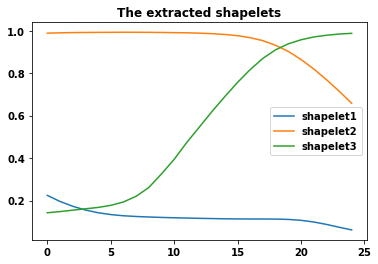

Validation balanced accuracy: 0.7741935483870968
Validation AUC: 0.910394265232975
Validation F1 score: 0.5625
Dataset number 2


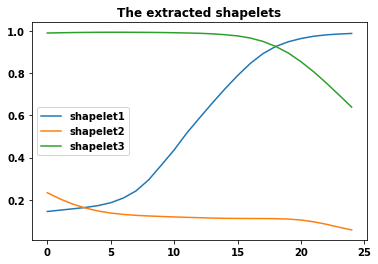

Validation balanced accuracy: 0.828125
Validation AUC: 0.90625
Validation F1 score: 0.5925925925925926
Dataset number 3


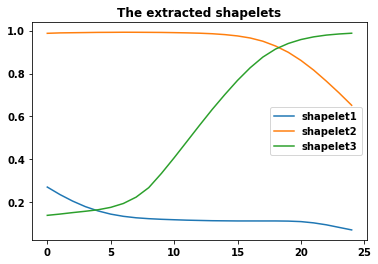

Validation balanced accuracy: 0.7241379310344828
Validation AUC: 0.9623824451410659
Validation F1 score: 0.5789473684210525
Dataset number 4


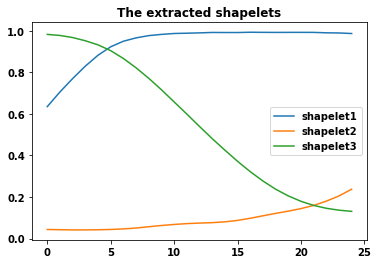

Validation balanced accuracy: 0.7307692307692308
Validation AUC: 0.9917582417582418
Validation F1 score: 0.6666666666666666


In [14]:
for sd in [1,2,3,4]:
    np.random.seed(sd)

    print(f'Dataset number {sd}')

    # Set up anomaly detection dataset
    
    normal_class = 1
    alpha = 0.05 # proportion of anomalies wrt normal 
    normal_prop = 0.65 # proportion of normal samples that go in train set
    valid_prop = 0.3 # proportion of validation data w.r.t. total data \ train data
    
    X_train_anomaly, y_train_anomaly, X_test_anomaly, y_test_anomaly, X_valid_anomaly, y_valid_anomaly = preprocessing_anomaly(X_train, \
        y_train, X_test, y_test, alpha, normal_class, normal_prop, valid_prop)
    
    # normalize the time series
    # as in the tutorial https://tslearn.readthedocs.io/en/stable/auto_examples/classification/plot_shapelets.html#sphx-glr-auto-examples-classification-plot-shapelets-py
    scaler = TimeSeriesScalerMinMax()
    X_train_anomaly = scaler.fit_transform(X_train_anomaly)
    X_test_anomaly = scaler.fit_transform(X_test_anomaly)
    X_valid_anomaly = scaler.fit_transform(X_valid_anomaly)
    
    N, Q, n_channels = X_train_anomaly.shape
    
    K = 3
    L = 25
    clusters_centers = get_weights_via_kmeans(X_train_anomaly, len_shapelets=L, num_shapelets=K, n_segments=10000)
    # set_shapelet_weights needs input of shape (num_shapelets, in_channels, len_shapelets)
    clusters_centers = clusters_centers.transpose(0,2,1)
    
    C = 1 / (N * alpha)
    extractor = LearningShapelets(len_shapelets=L, num_shapelets=K, in_channels=n_channels, C=C, verbose=0, to_cuda=False)
    extractor.set_shapelet_weights(clusters_centers)
    
    
    lr = 1e-3
    optimizer = torch.optim.SGD(extractor.model.parameters() ,lr=lr)
    extractor.set_optimizer(optimizer)
    
    n_epoch_steps = 20
    n_epochs = 4
    # total epochs = n_epoch_steps * n_epochs
    batch_size = 8
    
    # Input shape must be a pytorch TENSOR with shape (n_samples, in_channels, len_ts)
    X_train_tensor = tensor(X_train_anomaly, dtype=torch.float).contiguous().transpose(1,2)
    
    extractor.compute_radius(X_train_tensor, tol=1e-7)
    
    losses = []
    for _ in range(n_epoch_steps):
        extractor.compute_radius(X_train_tensor)
        losses += extractor.fit(X_train_tensor, epochs=n_epochs, batch_size=batch_size)
    
    # plot the shapelets
    
    S = extractor.get_shapelets()
    # use moveaxis because the shapelets returned have shape (num_shapelets, in_channels, shapelets_size)
    S = np.moveaxis(S, 1, 2)
    
    plt.figure()
    for i in range(len(S)):
        shap = S[i,:,]
        plt.plot(shap, label=f'shapelet{i+1}')
    plt.legend()
    plt.title('The extracted shapelets', fontweight="bold")
    plt.show()

    
    X_train_transform = extractor.transform(X_train_tensor)
    
    X_valid_tensor = tensor(X_valid_anomaly, dtype=torch.float).contiguous().transpose(1,2)
    X_valid_transform = extractor.transform(X_valid_tensor)
    
    svdd = SVDD(C=C, kernel='linear', zero_center=True, verbose=False)
    svdd.fit(X_train_transform)
    
    y_valid_predict = svdd.predict(X_valid_transform)
    ba = balanced_accuracy_score(y_valid_anomaly, y_valid_predict)
    
    # AUC
    y_valid_scores = svdd.decision_function(X_valid_transform)
    auc = roc_auc_score(y_valid_anomaly, y_valid_scores)
    
    f1_valid = f1_score(y_valid_anomaly, y_valid_predict)
    
    print(f'Validation balanced accuracy: {ba}')
    print(f'Validation AUC: {auc}')
    print("Validation F1 score:", f1_valid)